In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
class TransactionGraphBuilder:
    """Build graph structure from transaction data"""
    
    def __init__(self):
        self.account_to_idx = {}
        self.idx_to_account = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        
    def preprocess_features(self, df):
        """Enhanced feature preprocessing based on EDA insights"""
        df = df.copy()
        
        # Convert datetime
        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        df['hour'] = df['datetime'].dt.hour.astype('int8')
        df['day_of_week'] = df['datetime'].dt.dayofweek.astype('int8')
        df['weekend'] = (df['day_of_week'] >= 5).astype('int8')

        # Log transform amount (from EDA)
        df['log_amount'] = np.log1p(df['Amount']).astype('float32')
        
        # Cross-border transactions (high risk factor from EDA)
        df['cross_border'] = (df['Sender_bank_location'] != df['Receiver_bank_location']).astype('int8')

        # Currency mismatch
        df['currency_mismatch'] = (df['Payment_currency'] != df['Received_currency']).astype('int8')

        # High-risk countries (from research paper)
        high_risk_countries = ['Mexico', 'Turkey', 'Morocco', 'UAE']
        df['sender_high_risk'] = df['Sender_bank_location'].isin(high_risk_countries).astype('int8')
        df['receiver_high_risk'] = df['Receiver_bank_location'].isin(high_risk_countries).astype('int8')
        
        # Suspicious time patterns (from EDA - after midnight to early morning)
        df['suspicious_hour'] = ((df['hour'] >= 0) & (df['hour'] <= 6)).astype('int8')

        # Optimize memory usage
        df['Is_laundering'] = df['Is_laundering'].astype('int8')

        return df
    
    def calculate_graph_features(self, df, cutoff_date=None):
        """Calculate fan-in, fan-out, and transaction frequency features"""
        # Combine all accounts
        all_accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
        all_accounts.sort()
        account_features = pd.DataFrame(index=all_accounts)

        if cutoff_date:
            df_cut = df[df['Date'] <= cutoff_date].copy()
        else:
            df_cut = df.copy()

        # Fan-out: unique receivers per sender
        fan_out = df_cut.groupby('Sender_account')['Receiver_account'].nunique().reset_index()
        fan_out.columns = ['account', 'fan_out']
        
        # Fan-in: unique senders per receiver
        fan_in = df_cut.groupby('Receiver_account')['Sender_account'].nunique().reset_index()
        fan_in.columns = ['account', 'fan_in']
        
        # Transaction frequency as sender
        sender_freq = df_cut.groupby('Sender_account').size().reset_index()
        sender_freq.columns = ['account', 'sender_frequency']
        
        # Transaction frequency as receiver
        receiver_freq = df_cut.groupby('Receiver_account').size().reset_index()
        receiver_freq.columns = ['account', 'receiver_frequency']
        
        # Merge features
        account_features['fan_out'] = account_features.index.map(
            fan_out.set_index('account')['fan_out']
        )
        account_features['fan_in'] = account_features.index.map(
            fan_in.set_index('account')['fan_in']
        )
        account_features['sender_frequency'] = account_features.index.map(
            sender_freq.set_index('account')['sender_frequency']
        )
        account_features['receiver_frequency'] = account_features.index.map(
            receiver_freq.set_index('account')['receiver_frequency']
        )

        # Fill missing values
        account_features = account_features.fillna(0)

        del fan_out, fan_in, sender_freq, receiver_freq
        
        return account_features.reset_index().rename(columns={'index': 'account'})
    
    def encode_categorical_features(self, df, fit=True):
        """Encode categorical features"""
        categorical_cols = ['Payment_type', 'Sender_bank_location', 'Receiver_bank_location', 
                           'Payment_currency', 'Received_currency']
        
        for col in categorical_cols:
            if fit:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                encoded_values = self.label_encoders[col].fit_transform(df[col].astype(str))
            else:
                encoded_values = self.label_encoders[col].transform(df[col].astype(str))

            # Check if values fit in int8 range (0-127 for positive values)
            max_encoded = encoded_values.max()
            if max_encoded <= 127:
                df[f'{col}_encoded'] = encoded_values.astype('int8')
            elif max_encoded <= 32767:
                df[f'{col}_encoded'] = encoded_values.astype('int16')
                print(f"Warning: {col} has {max_encoded} unique values, using int16")
            else:
                df[f'{col}_encoded'] = encoded_values.astype('int32')
                print(f"Warning: {col} has {max_encoded} unique values, using int32")

        return df
    
    def clean_unwanted_features(self, df):
        """Remove unnecessary features"""
        unwanted_cols = ['Time', 'Payment_type', 'Sender_bank_location', 'Receiver_bank_location',
                         'Payment_currency', 'Received_currency', 'Amount', 'Laundering_type']
        df = df.drop(columns=unwanted_cols)
        return df

    def build_graph(self, df, train_cutoff, val_cutoff, max_nodes=50000):
        """Build graph from transaction data with memory optimization"""
        print("Preprocessing features...")
        df = self.preprocess_features(df)
        df = self.encode_categorical_features(df)
        df = self.clean_unwanted_features(df)
        
        # Sample data if too large for memory constraints
        if len(df) > max_nodes:
            print(f"Sampling {max_nodes} transactions from {len(df)} total")
            # Stratified sampling to maintain class balance
            suspicious = df[df['Is_laundering'] == 1]
            normal = df[df['Is_laundering'] == 0].sample(n=max_nodes-len(suspicious), random_state=42)
            df = pd.concat([suspicious, normal]).reset_index(drop=True)
        
        print("Building account mapping...")
        # Create account mappings
        all_accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
        self.account_to_idx = {acc: idx for idx, acc in enumerate(all_accounts)}
        self.idx_to_account = {idx: acc for acc, idx in self.account_to_idx.items()}
        
        print("Calculating graph features...")
        # Calculate account-level features
        account_features_train = self.calculate_graph_features(df, train_cutoff)
        account_features_val = self.calculate_graph_features(df, val_cutoff)
        account_features_test = self.calculate_graph_features(df)
        
        # Create node features matrix
        num_nodes = len(all_accounts)
        node_features_train = np.zeros((num_nodes, 4))  # fan_out, fan_in, sender_freq, receiver_freq
        node_features_val = np.zeros((num_nodes, 4))
        node_features_test = np.zeros((num_nodes, 4))
        
        # Slow 
        for _, row in account_features_train.iterrows():
            idx = self.account_to_idx[row['account']]
            node_features_train[idx] = [row['fan_out'], row['fan_in'], 
                                row['sender_frequency'], row['receiver_frequency']]
        
        for _, row in account_features_val.iterrows():
            idx = self.account_to_idx[row['account']]
            node_features_val[idx] = [row['fan_out'], row['fan_in'], 
                                row['sender_frequency'], row['receiver_frequency']]

        for _, row in account_features_test.iterrows():
            idx = self.account_to_idx[row['account']]
            node_features_test[idx] = [row['fan_out'], row['fan_in'], 
                                row['sender_frequency'], row['receiver_frequency']]

        print("Creating edges and edge features...")

        feature_columns = [
                'log_amount', 'hour', 'day_of_week', 'weekend', 'cross_border',
                'currency_mismatch', 'sender_high_risk', 'receiver_high_risk',
                'suspicious_hour', 'Payment_type_encoded', 'Sender_bank_location_encoded',
                'Receiver_bank_location_encoded'
                ]

        sender_mapped = df['Sender_account'].map(self.account_to_idx)
        receiver_mapped = df['Receiver_account'].map(self.account_to_idx)
        edge_list = np.column_stack((sender_mapped, receiver_mapped))
        edge_features = df[feature_columns].values
        edge_labels = df['Is_laundering'].values
        
        # Convert to tensors
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        node_features_train = torch.tensor(node_features_train, dtype=torch.float)
        node_features_val = torch.tensor(node_features_val, dtype=torch.float)
        node_features_test = torch.tensor(node_features_test, dtype=torch.float)
        edge_features = torch.tensor(edge_features, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        
        # Standardize features
        node_features_train = torch.tensor(self.scaler.fit_transform(node_features_train), dtype=torch.float)
        node_features_val = torch.tensor(self.scaler.transform(node_features_val), dtype=torch.float)
        node_features_test = torch.tensor(self.scaler.transform(node_features_test), dtype=torch.float)
        edge_features = torch.tensor(self.scaler.fit_transform(edge_features), dtype=torch.float)

        # Mask
        train_size = len(df[df['Date'] <= train_cutoff])
        val_size = len(df[(df['Date'] > train_cutoff) & (df['Date'] <= val_cutoff)])
        indices = torch.arange(len(edge_list))
        train_mask = indices[:train_size]
        val_mask = indices[train_size:train_size+val_size]
        test_mask = indices[train_size+val_size:]
        
        # Create PyTorch Geometric data object
        train_data = Data(
            x=node_features_train,
            edge_index=edge_index[:, train_mask],
            edge_attr=edge_features[train_mask],
            y=edge_labels[train_mask]
        )
        val_data = Data(
            x=node_features_val,
            edge_index=edge_index[:, val_mask],
            edge_attr=edge_features[val_mask],
            y=edge_labels[val_mask]
        )
        test_data = Data(
            x=node_features_test,
            edge_index=edge_index[:, test_mask],
            edge_attr=edge_features[test_mask],
            y=edge_labels[test_mask]
        )

        print(f"Graph created: {num_nodes} nodes, {len(edge_list)} edges")
        print(f"Suspicious transactions: {edge_labels.sum().item()} ({edge_labels.float().mean()*100:.3f}%)")
        
        return train_data, val_data, test_data

In [4]:
# Model
class GraphSAGE(nn.Module):
    """GraphSAGE model for transaction classification"""
    
    def __init__(self, num_node_features, num_edge_features, hidden_dim=128, num_layers=3, dropout=0.3):
        super(GraphSAGE, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node embedding layers
        self.node_convs = nn.ModuleList()
        self.node_convs.append(SAGEConv(num_node_features, hidden_dim))
        for _ in range(num_layers - 1):
            self.node_convs.append(SAGEConv(hidden_dim, hidden_dim))
        
        # Edge feature processing
        self.edge_mlp = nn.Sequential(
            nn.Linear(num_edge_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),  # sender + receiver + edge features
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 2)
        )
        
    def forward(self, x, edge_index, edge_attr, batch=None):
        # Node embeddings through GraphSAGE layers
        h = x
        for i, conv in enumerate(self.node_convs):
            h = conv(h, edge_index)
            if i < len(self.node_convs) - 1:
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Process edge features
        edge_emb = self.edge_mlp(edge_attr)
        
        # Combine sender and receiver embeddings with edge features
        sender_emb = h[edge_index[0]]  # Sender embeddings
        receiver_emb = h[edge_index[1]]  # Receiver embeddings
        
        # Concatenate all features
        combined = torch.cat([sender_emb, receiver_emb, edge_emb], dim=1)
        
        # Final classification
        out = self.classifier(combined)
        
        return out

In [5]:
class AMLTrainer:
    """Training pipeline for AML detection"""
    
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        
    def train_epoch(self, data, optimizer, criterion):
        self.model.train()
        optimizer.zero_grad()
        
        out = self.model(data.x, data.edge_index, data.edge_attr)
        
        # Apply class weights for imbalanced data
        weight = self.class_weights.to(self.device)
        loss = F.cross_entropy(out, data.y, weight=weight)
        
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    def evaluate(self, data):
        self.model.eval()
        with torch.no_grad():
            out = self.model(data.x, data.edge_index, data.edge_attr)
            pred = out.argmax(dim=1)

            # Calculate loss (weighted, for consistency with training)
            weight = self.class_weights.to(self.device)
            loss = F.cross_entropy(out, data.y, weight=weight).item()
            
            # Calculate metrics
            y_true = data.y.cpu().numpy()
            y_pred = pred.cpu().numpy()
            y_prob = F.softmax(out, dim=1)[:, 1].cpu().numpy()
            
            accuracy = (pred == data.y).float().mean().item()
            recall = recall_score(y_true, y_pred, average='binary')
            f2 = fbeta_score(y_true, y_pred, beta=2, average='binary')  # F2 score with beta=2
            
            return loss, accuracy, recall, f2, y_true, y_pred, y_prob
    
    def train(self, train_data, val_data, epochs=100, lr=0.001, patience=10):
        # Calculate class weights for imbalanced data
        _class_weights = compute_class_weight(
            'balanced', 
            classes=np.unique(train_data.y.cpu().numpy()), 
            y=train_data.y.cpu().numpy()
        )
        # Fine-tune weight to balance precision and recall
        _class_weights[1] *= 0.8  # Increase weight for laundering class to boost recall
        self.class_weights = torch.tensor(_class_weights, dtype=torch.float).to(self.device)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=5, factor=0.5, mode='max' # Mode 'max' for F2 score
        )
        
        best_f2 = 0
        patience_counter = 0
        train_losses = []
        val_losses = []
        val_f2s = []
        
        print("Starting training...")
        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(train_data, optimizer, F.cross_entropy)
            
            # Validation
            val_loss, val_acc, val_recall, val_f2, _, _, _ = self.evaluate(val_data)

            scheduler.step(val_f2)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_f2s.append(val_f2)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Recall: {val_recall:.4f}, Val F2: {val_f2:.4f}')

            # Early stopping
            if val_f2 > best_f2:
                best_f2 = val_f2
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pt'))
        print(f'Training completed. Best validation F2: {best_f2:.4f}')

        return train_losses, val_losses, val_f2s

In [6]:
# Load the entire dataset
df = pd.read_csv(DATAPATH)

# Filter by data range
# df = df[df['Date'] < '2023-05-31']

In [7]:
print(f"Dataset shape: {df.shape}")
print(f"Suspicious transactions: {df['Is_laundering'].sum()} ({df['Is_laundering'].mean()*100:.4f}%)")

Dataset shape: (9504852, 12)
Suspicious transactions: 9873 (0.1039%)


In [8]:
# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# test_dt = 35
# validation_dt = 70
# test_cutoff = df['Date'].max() - pd.Timedelta(days=test_dt)
# validation_cutoff = test_cutoff - pd.Timedelta(days=validation_dt)

# # val_size = len(df[(df.Date >= validation_cutoff) & (df.Date < test_cutoff)])
# # train_size = len(df[df.Date < validation_cutoff])
# # print(f"Train size: {train_size}, Validation size: {val_size}")
# print(test_cutoff)
# print(validation_cutoff)

In [9]:
# # Build graph
# graph_builder = TransactionGraphBuilder()
# df = graph_builder.preprocess_features(df)
# acc_features = graph_builder.calculate_graph_features(df, cutoff_date='2022-12-31')

In [20]:
# Build graph
graph_builder = TransactionGraphBuilder()
# train_cutoff = '2023-05-15'
# val_cutoff = '2023-07-19'
train_cutoff = '2023-03-31'
val_cutoff = '2023-05-15'
train_data, val_data, test_data = graph_builder.build_graph(df, train_cutoff, val_cutoff, max_nodes=10000000)

Preprocessing features...
Building account mapping...
Calculating graph features...
Creating edges and edge features...
Graph created: 855460 nodes, 9504852 edges
Suspicious transactions: 9873 (0.104%)


In [21]:
train_size = len(df[df['Date'] <= train_cutoff])
val_size = len(df[(df['Date'] > train_cutoff) & (df['Date'] <= val_cutoff)])
test_size = len(df[df['Date'] > val_cutoff])
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 5228304, Validation size: 1820484, Test size: 2456064


In [22]:
print(f"Train edges: {train_data.edge_index.shape[1]}")
print(f"Train suspicious: {train_data.y.sum().item()} ({train_data.y.float().mean()*100:.4f}%)")
print(f"Val edges: {val_data.edge_index.shape[1]}")
print(f"Val suspicious: {val_data.y.sum().item()} ({val_data.y.float().mean()*100:.4f}%)")
print(f"Test edges: {test_data.edge_index.shape[1]}")
print(f"Test suspicious: {test_data.y.sum().item()} ({test_data.y.float().mean()*100:.4f}%)")

Train edges: 5228304
Train suspicious: 5208 (0.0996%)
Val edges: 1820484
Val suspicious: 1828 (0.1004%)
Test edges: 2456064
Test suspicious: 2837 (0.1155%)


In [23]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(
    num_node_features=train_data.x.shape[1],
    num_edge_features=train_data.edge_attr.shape[1],
    hidden_dim=128,
    num_layers=3,
    dropout=0.3
)
    
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 142,786


In [24]:
# Move data to device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [25]:
# Train model
trainer = AMLTrainer(model, device)
train_losses, val_losses, val_f2s = trainer.train(train_data, val_data, epochs=100, lr=0.001)

Starting training...
Epoch 000: Train Loss: 0.6865, Val Loss: 0.6442, Val Recall: 0.0000, Val F2: 0.0000
Epoch 010: Train Loss: 0.3048, Val Loss: 0.2778, Val Recall: 0.8359, Val F2: 0.0829
Epoch 020: Train Loss: 0.1541, Val Loss: 0.1149, Val Recall: 0.9382, Val F2: 0.0913
Epoch 030: Train Loss: 0.1246, Val Loss: 0.0913, Val Recall: 0.9458, Val F2: 0.1100
Epoch 040: Train Loss: 0.0958, Val Loss: 0.0712, Val Recall: 0.9666, Val F2: 0.1302
Epoch 050: Train Loss: 0.0881, Val Loss: 0.0605, Val Recall: 0.9644, Val F2: 0.4187
Epoch 060: Train Loss: 0.0720, Val Loss: 0.0496, Val Recall: 0.9710, Val F2: 0.4336
Epoch 070: Train Loss: 0.0719, Val Loss: 0.0430, Val Recall: 0.9726, Val F2: 0.4742
Early stopping at epoch 78
Training completed. Best validation F2: 0.4779


In [26]:
# Evaluate on test set
test_loss, test_acc, test_recall, test_f2, y_true, y_pred, y_prob = trainer.evaluate(test_data)

print(f"\nTest Results:")
print(f"Recall: {test_recall:.4f}")
print(f"F2 Score: {test_f2:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Suspicious']))


Test Results:
Recall: 0.9736
F2 Score: 0.5823

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00   2453227
  Suspicious       0.22      0.97      0.36      2837

    accuracy                           1.00   2456064
   macro avg       0.61      0.98      0.68   2456064
weighted avg       1.00      1.00      1.00   2456064



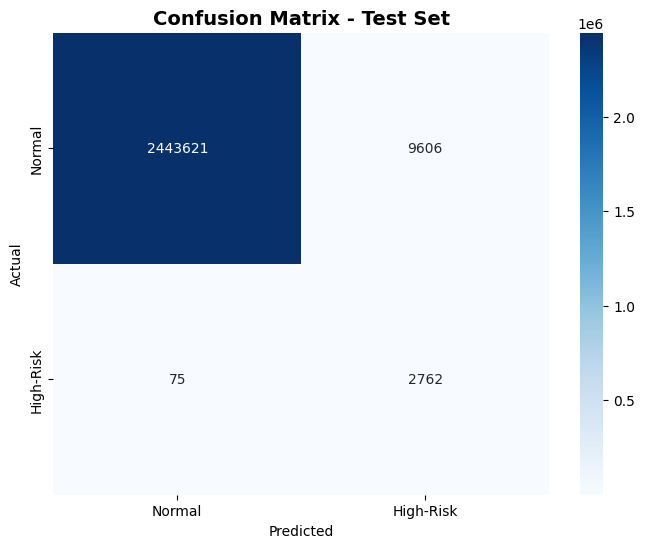

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

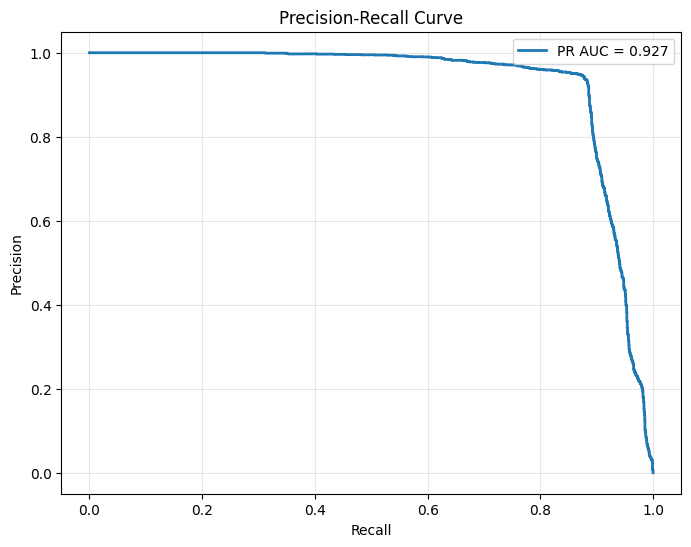

PR AUC Score: 0.9273


In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate PR curve data
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"PR AUC Score: {pr_auc:.4f}")


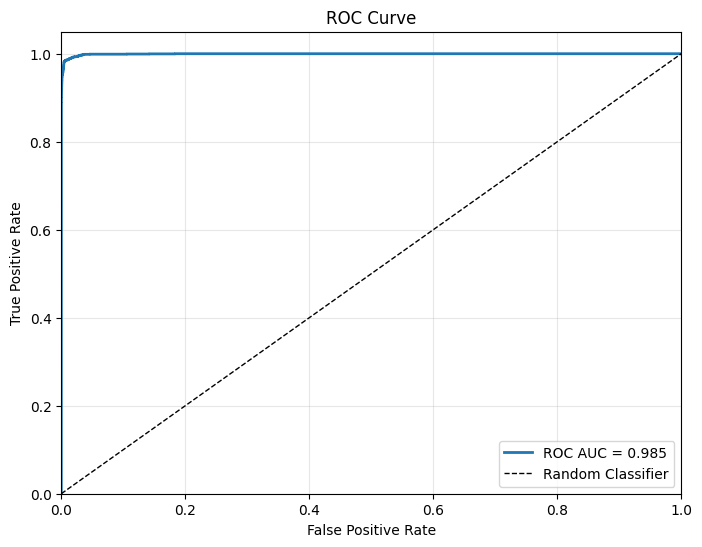

ROC AUC Score: 0.9848


In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

In [30]:
for threshold in [0.5, 0.8, 0.9, 0.95, 0.99]:
    y_pred = (y_prob >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Threshold: {threshold}, precision: {precision}, recall: {recall}")

Threshold: 0.5, precision: 0.22331824062095731, recall: 0.9735636235459993
Threshold: 0.8, precision: 0.5296812749003984, recall: 0.9372576665491716
Threshold: 0.9, precision: 0.7948637644848106, recall: 0.8946069792033838
Threshold: 0.95, precision: 0.8975365940735451, recall: 0.8861473387381036
Threshold: 0.99, precision: 0.9542743538767395, recall: 0.8459640465280226
